**tldr:**
- we finetuned (with hqq-qdora) llama2-7b and llama3-8b for 8,4,3,2,1 bits respectively
- for known results (8,4bits), we reproduce the same behavior as Kerem from answer.ai
- we observe:
    - using 1 bit makes the model useless
    - using 2 bit represents a bad trade-off re quality and memory/speed
    - using 3 bit represents a really good trade-off re quality and memory/speed!
    - (tentative:) memory usage and time are ~equal regardless of bits. (**ToDo Umer:** This is implausible to me -> Investigate)
    - these observations are consistent accross llama2 and llama3
- Note: Mobius Labs claim the quality drop when going from 3 -> 2 and 2 -> 1 bits is smaller for larger models.

In [1]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt

from fastcore.basics import listify

from itertools import pairwise

In [2]:
api = wandb.Api()

In [3]:
runs = {
    'llama3': {
        '8bit': 'umerha/llama3-8b-quant-ft-8bit/i4ppd3ds',
        '4bit': 'umerha/llama3-8b-quant-ft-4bit/qmy84a83',
        '3bit': 'umerha/llama3-8b-quant-ft-3bit/c3sdx6vt',
        '2bit': 'umerha/llama3-8b-quant-ft-2bit/1usdhjo0',
        '1bit': 'umerha/llama3-8b-quant-ft-1bit/gbbvs2n1',
    },
    'llama2': {
        '8bit': 'umerha/llama2-7b-quant-ft-8bit/9b38a489',
        '4bit': 'umerha/llama2-7b-quant-ft-4bit/xbogqmb1',
        '3bit': 'umerha/llama2-7b-quant-ft-3bit/9c1q0vfr',
        '2bit': 'umerha/llama2-7b-quant-ft-2bit/5mf3ilzl',
        '1bit': 'umerha/llama2-7b-quant-ft-1bit/zniprcth',
    }
}

In [4]:
def get_loss(run): return api.run(run).history()['loss'] # pandas series

In [5]:
def remove_nans(loss):
    # loss data from w&b has some nans, which should only be at the start and end of a run
    a = loss.first_valid_index() # nans from setup
    b = loss.last_valid_index()  # nans from wind-down
    assert loss.iloc[a:b+1].notna().all(), f'There are nans in the actual run, ie not during setup (until incl. {a-1}) and wind-down (from incl. {b+1}).'
    return loss.iloc[a:b+1]

In [6]:
def smooth(loss, alpha=0.99):
    alpha = 1 - alpha # in w&b ui, higher alpha = more smoothed
    return loss.ewm(alpha=alpha).mean()

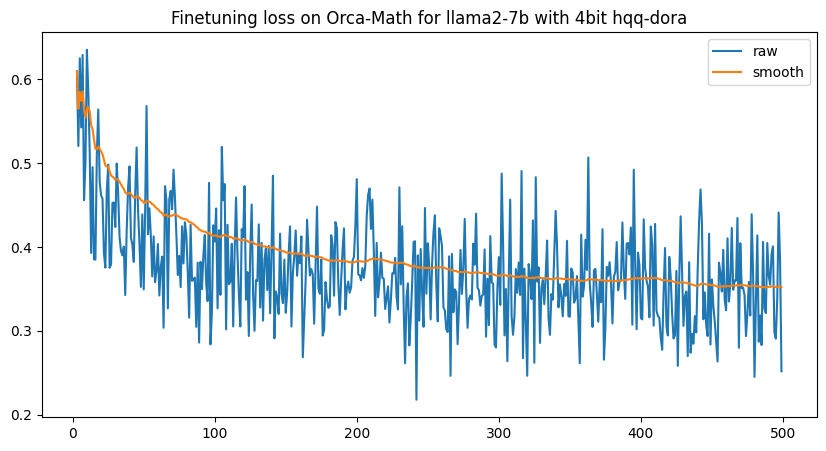

In [7]:
raw_loss = get_loss(runs['llama2']['4bit'])
loss = remove_nans(raw_loss)
loss_smooth = smooth(loss)

plt.figure(figsize=(10, 5))
plt.plot(loss, label='raw')
plt.plot(loss_smooth, label='smooth')
plt.title('Finetuning loss on Orca-Math for llama2-7b with 4bit hqq-dora')
plt.legend()
plt.show()

In [8]:
raw_loss

0           NaN
1           NaN
2           NaN
3      0.609624
4      0.520553
         ...   
495    0.290900
496    0.337698
497    0.441282
498    0.383059
499    0.251848
Name: loss, Length: 500, dtype: float64

In [9]:
api.run('umerha/llama2-7b-quant-ft-4bit/xbogqmb1').history()['loss']

0           NaN
1           NaN
2      0.520553
3      0.629095
4      0.547559
         ...   
495    0.404834
496    0.359658
497    0.322206
498    0.328325
499         NaN
Name: loss, Length: 500, dtype: float64

In [10]:
api.run('umerha/llama2-7b-quant-ft-4bit/xbogqmb1').history()['loss']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
495    0.290900
496    0.310337
497    0.332124
498         NaN
499         NaN
Name: loss, Length: 500, dtype: float64

In [11]:
api.run('umerha/llama2-7b-quant-ft-4bit/xbogqmb1').history()['loss']

0           NaN
1           NaN
2           NaN
3           NaN
4      0.706271
         ...   
495    0.337698
496    0.441282
497    0.332124
498    0.251848
499         NaN
Name: loss, Length: 500, dtype: float64

**ToDo:** Why does the api return different losses for the exact same run? w&b resamples to 500 steps. Does that introduce randomness?

Looks good for one run, let's now get the smoothed losses for all runs.

In [12]:
def tfm_nested_dict(dct, fn):
    # same structure as dict_, with fn applied to each node
    return {
        model_k: { run_k: fn(run_v) for run_k, run_v in model_v.items() }
        for model_k,model_v in dct.items()
    }  

In [13]:
raw_losses = tfm_nested_dict(runs, get_loss)
losses = tfm_nested_dict(raw_losses, remove_nans)
smooth_losses = tfm_nested_dict(losses, smooth)

As sanity-check, let's plot the unsmoothed losses. 1bit should be way worse than th others, as seen in the w&b web interface.

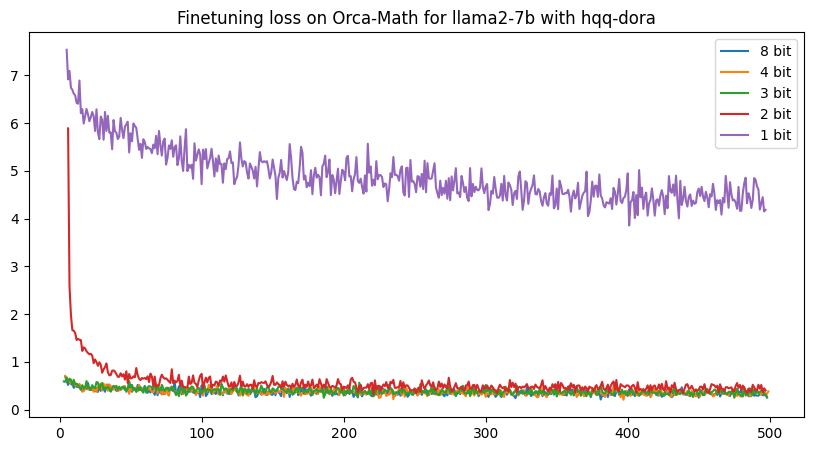

In [14]:
plt.figure(figsize=(10, 5))
for b in [8,4,3,2,1]:
    plt.plot(losses['llama2'][f'{b}bit'], label=f'{b} bit')
plt.title('Finetuning loss on Orca-Math for llama2-7b with hqq-dora')
plt.legend()
plt.show()

Looks good.

In [15]:
def plot_losses(bits, ymax=None):
    bits = listify(bits)
    plt.figure(figsize=(15, 5))
    for b in bits:
        plt.plot(smooth_losses['llama2'][f'{b}bit'], label=f'{b} bit')
    plt.title('Finetuning loss on Orca-Math for llama2-7b with hqq-dora')
    plt.legend()
    plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0, top=ymax)
    plt.show()

As sanity-check, let's compare the 4bit loss curve to the Kerem's curve from the [answer qdora post](http://www.answer.ai/posts/2024-04-26-fsdp-qdora-llama3.html) (green one in image below). They should be identical (up to smoothing).

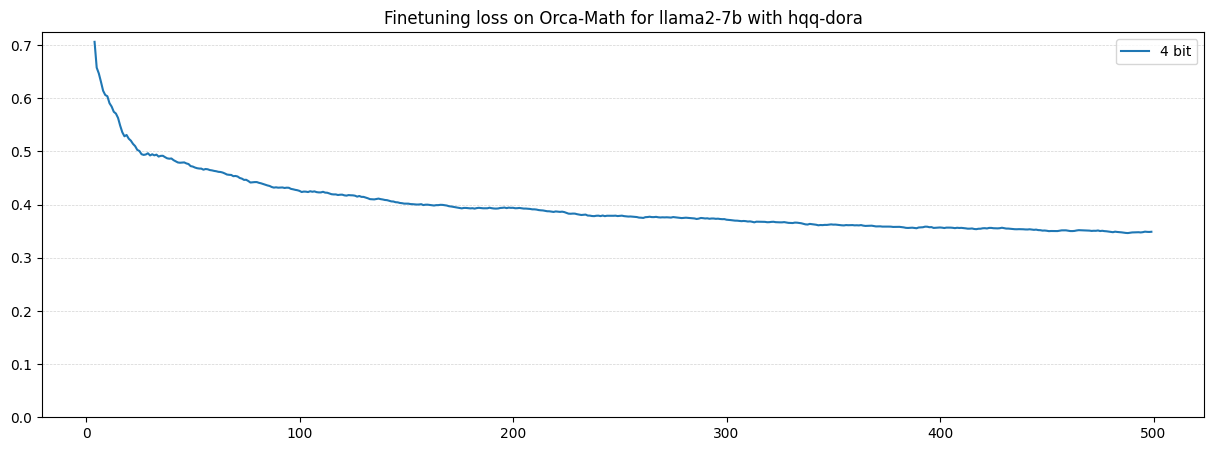

In [16]:
plot_losses(bits=4)

<img src='http://www.answer.ai/posts/images/qdora-llama3/image6.png'>

Look very similar. That's good.

The steps are different because (i) Kerem used a different batch size and (ii) w&b normalizes steps to 500 (we'd have 10k/(4*2)=1250, as we used bs = 4 and grad_accum_steps = 2)

Okay, let's observe

### Lllama2-7b

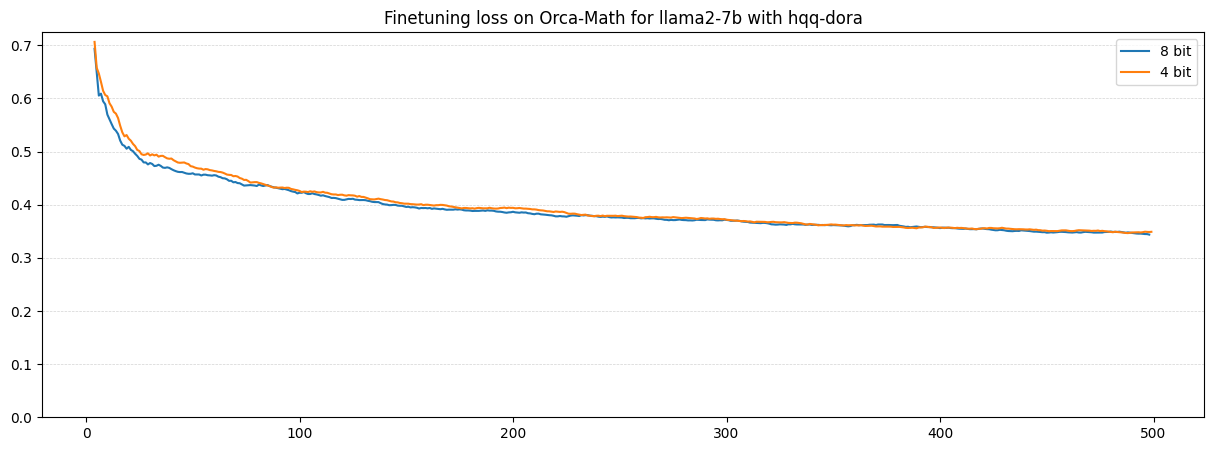

In [17]:
plot_losses(bits=[8,4])

**Obeservation 1:** There's no loss in quality going from 8bit to 4bit.

This is expected, as Kerem used 4bit in the [answer qdora post](http://www.answer.ai/posts/2024-04-26-fsdp-qdora-llama3.html), which he presumibly only did because it's not worse than 8bit.

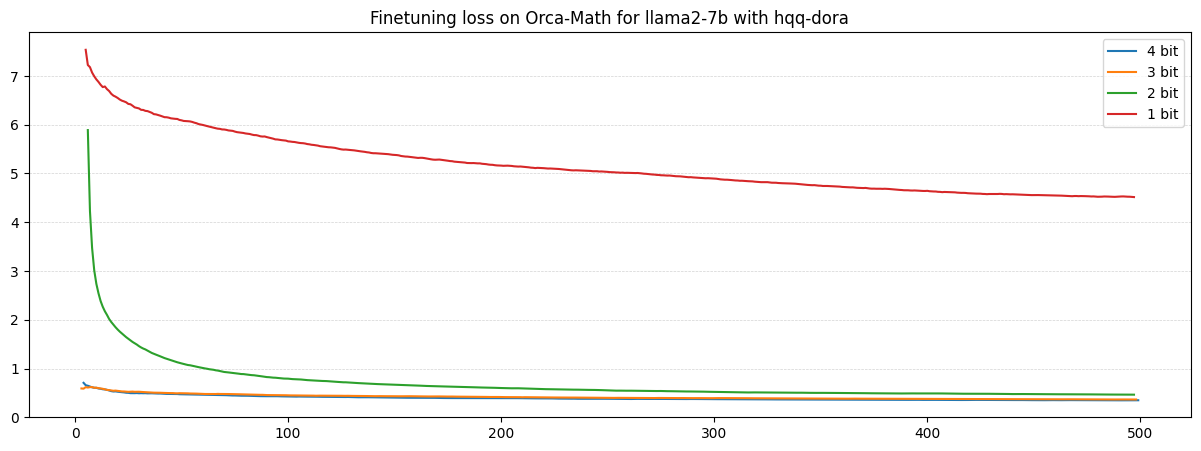

In [18]:
plot_losses(bits=[4,3,2,1])

**Observation 2:** 1bit is really bad.

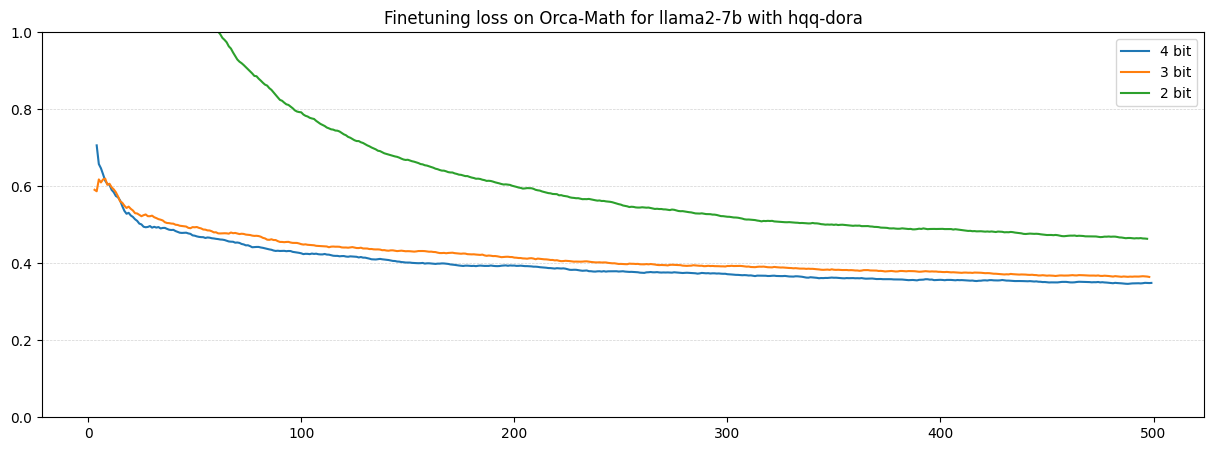

In [19]:
plot_losses(bits=[4,3,2], ymax=1)

**Observation 3:** 2 bit is still bad, but
- there might be a trade-off: it should be faster so can be trained more in the same time. It might end up better after all. Would need to investigate.
- it needs less memory than than 4/3-bit models.

If we pursue this path, we might end up with a better model with lower memory requirement. I personally have a low-confidence believe it's not worth it to pursue this further.

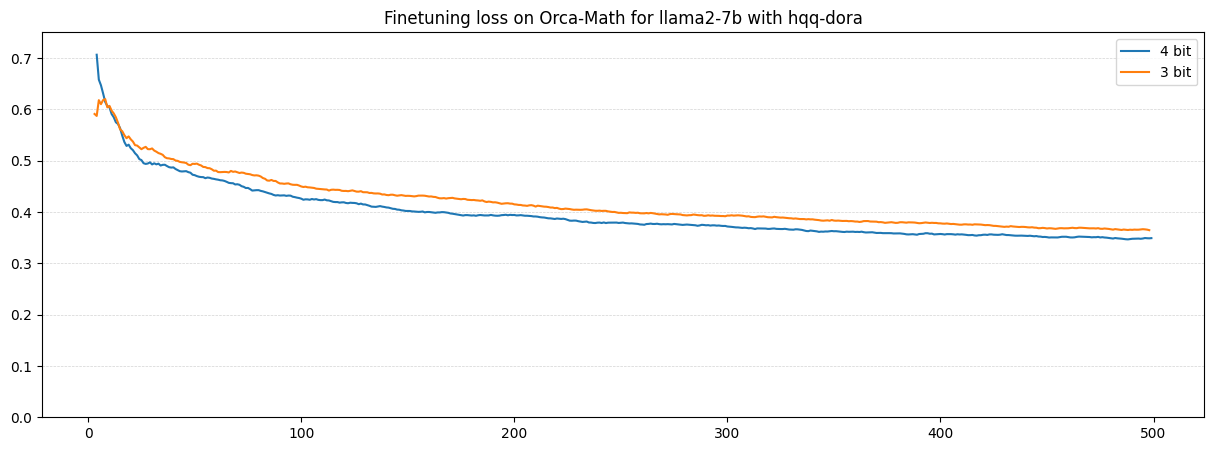

In [20]:
plot_losses(bits=[4,3], ymax=.75)

**Observation 4:** 3bit is only slightly worse than 4bit. It's ~5% worse (see below for details), but needs ~25% less memory and should be faster.

Using the extra time gained from faster training to train for longer, the 3bit model might even be better than the 4bit model. Need to investigate. To me personally, this looks very promising.

In [21]:
def take_final_value(srs): return srs.iloc[-1]
final_losses = tfm_nested_dict(smooth_losses, take_final_value)

Without using the extra time gained from faster training to train for longer, this is the quality / memory trade-off we get:

In [22]:
for b_large,b_small in pairwise((4,3,2)):
    loss_incr = (final_losses['llama2'][f'{b_small}bit'] / final_losses['llama2'][f'{b_large}bit'] - 1)
    memory_decr = 1 - b_small/b_large
    print(f'Going from {b_large}bit to {b_small}bit decreases memory by {memory_decr*100:>4.1f}%, but increase loss by {loss_incr*100:>4.1f}%')

Going from 4bit to 3bit decreases memory by 25.0%, but increase loss by  4.5%
Going from 3bit to 2bit decreases memory by 33.3%, but increase loss by 27.2%


In [23]:
def get_time(run): return api.run(run).summary['time_taken']
def get_max_mem(run): return api.run(run).summary['memory/reserved_peak']

In [24]:
times = tfm_nested_dict(runs, get_time)
mems = tfm_nested_dict(runs, get_max_mem)

In [25]:
times['llama2']

{'8bit': 7558.71,
 '4bit': 7465.139,
 '3bit': 7459.3785,
 '2bit': 7394.938,
 '1bit': 7451.202}

In [26]:
mems['llama2']

{'8bit': 24591204352,
 '4bit': 24456986624,
 '3bit': 24089985024,
 '2bit': 24232591360,
 '1bit': 24687673344}

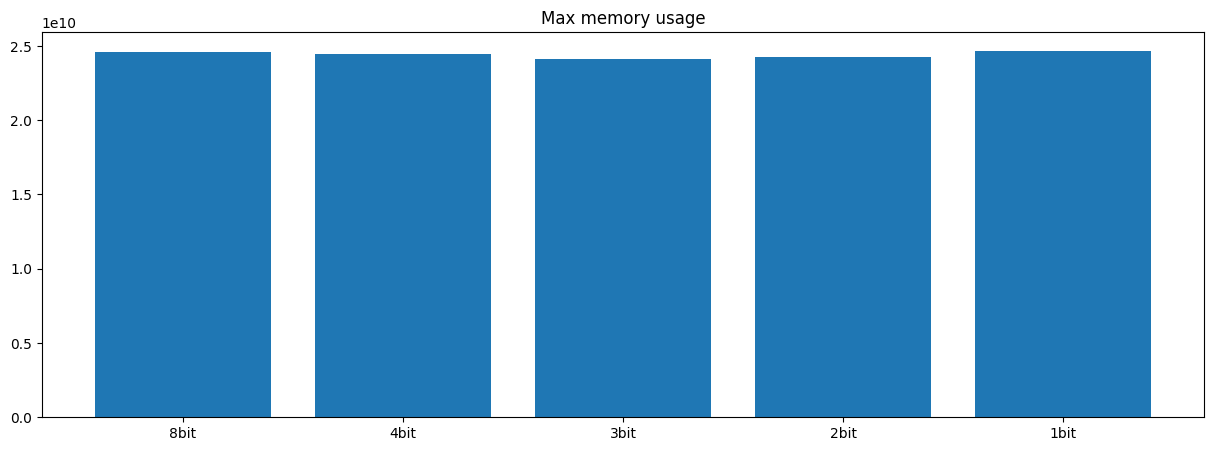

In [27]:
plt.figure(figsize=(15, 5))
plt.bar(mems['llama2'].keys(), mems['llama2'].values())
plt.title('Max memory usage')
plt.show()

**(Tentative) Observation 5:** The max memory usage is ~equal, regardless of bits.

This is surprising to me. I would have expected decreasing memory usage. **ToDo:** Investigate.

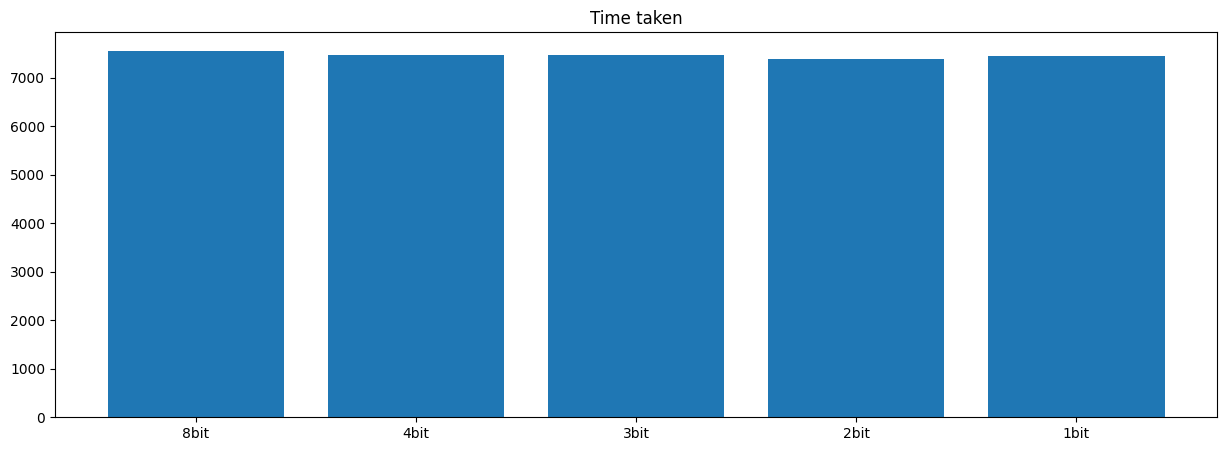

In [28]:
plt.figure(figsize=(15, 5))
plt.bar(times['llama2'].keys(), times['llama2'].values())
plt.title('Time taken')
plt.show()

**(Tentative) Observation 6:** The time taken is ~equal, regardless of bits.

This is surprising to me. I would have expected decreasing time taken usage. **ToDo:** Investigate.

### Llama3-8b

In [29]:
def plot_losses_llama3(bits, ymax=None):
    bits = listify(bits)
    plt.figure(figsize=(15, 5))
    for b in bits:
        plt.plot(smooth_losses['llama3'][f'{b}bit'], label=f'{b} bit')
    plt.title('Finetuning loss on Orca-Math for llama3-8b with hqq-dora')
    plt.legend()
    plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0, top=ymax)
    plt.show()

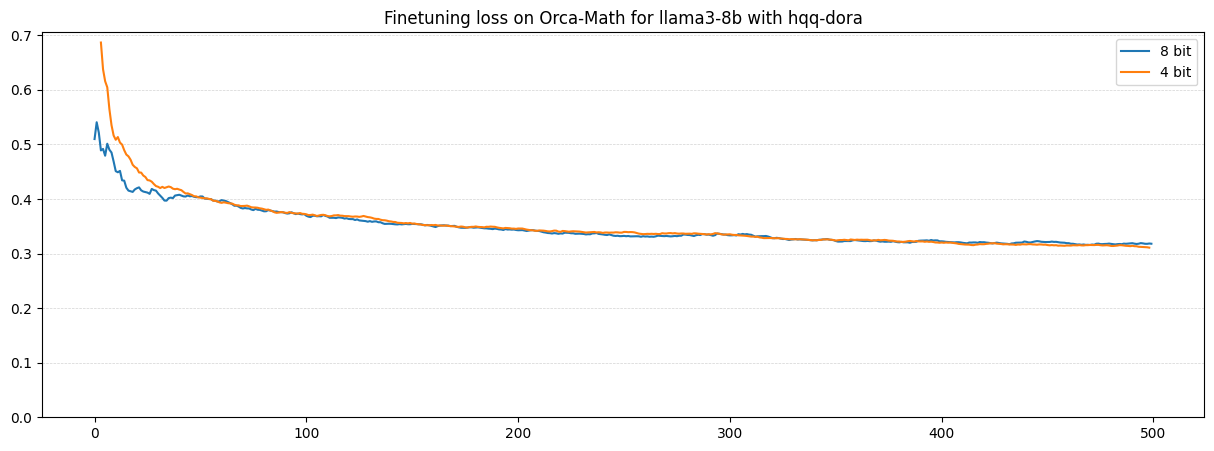

In [30]:
plot_losses_llama3(bits=[8,4])

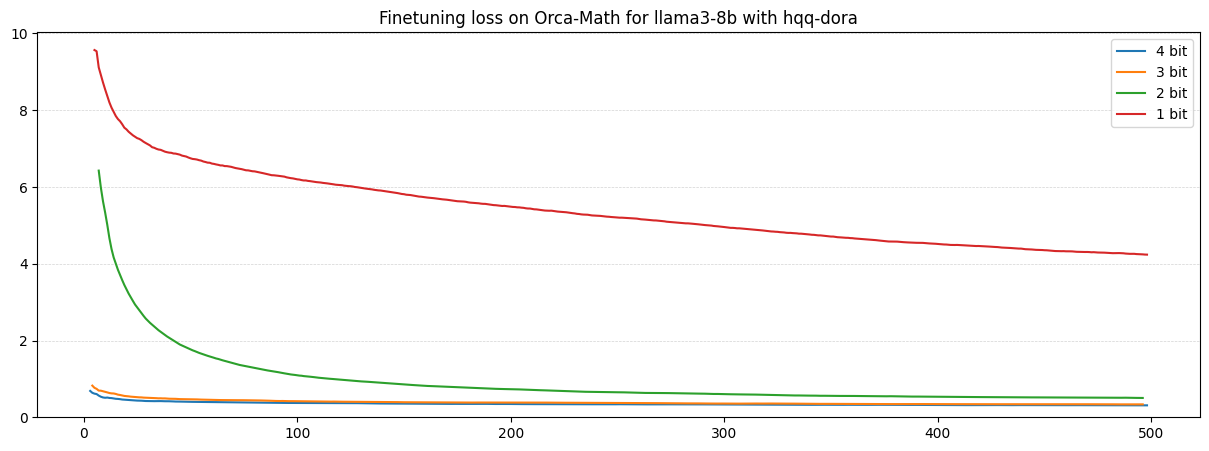

In [31]:
plot_losses_llama3(bits=[4,3,2,1])

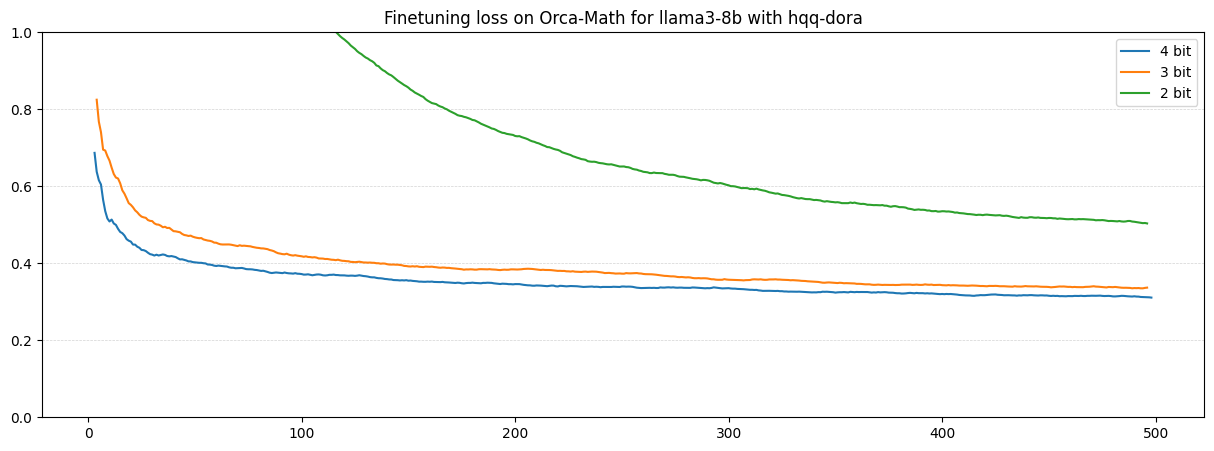

In [32]:
plot_losses_llama3(bits=[4,3,2], ymax=1)

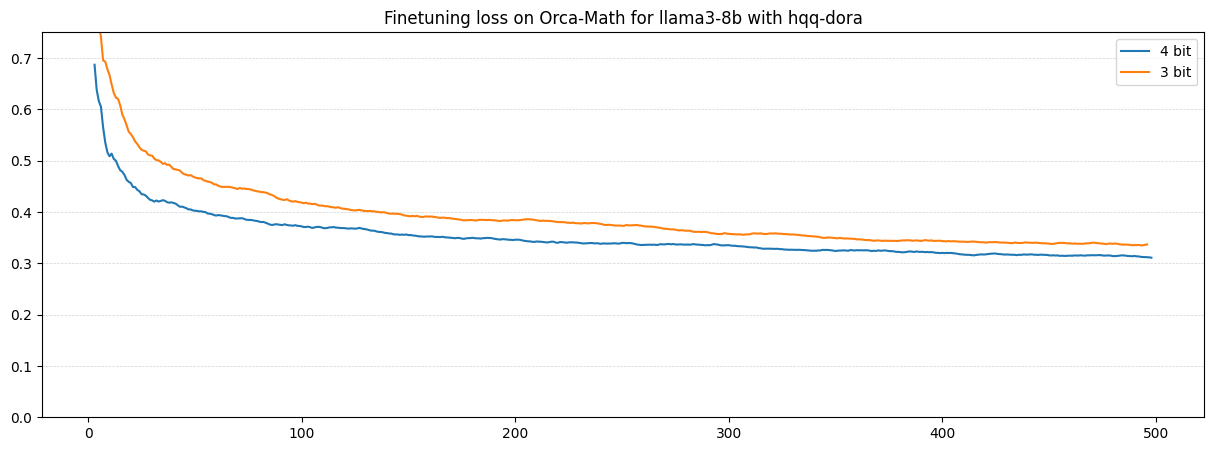

In [33]:
plot_losses_llama3(bits=[4,3], ymax=.75)

In [34]:
for b_large,b_small in pairwise((4,3,2)):
    loss_incr = (final_losses['llama3'][f'{b_small}bit'] / final_losses['llama3'][f'{b_large}bit'] - 1)
    memory_decr = 1 - b_small/b_large
    print(f'[Llama3] Going from {b_large}bit to {b_small}bit decreases memory by {memory_decr*100:>4.1f}%, but increase loss by {loss_incr*100:>4.1f}%')

[Llama3] Going from 4bit to 3bit decreases memory by 25.0%, but increase loss by  8.3%
[Llama3] Going from 3bit to 2bit decreases memory by 33.3%, but increase loss by 49.5%


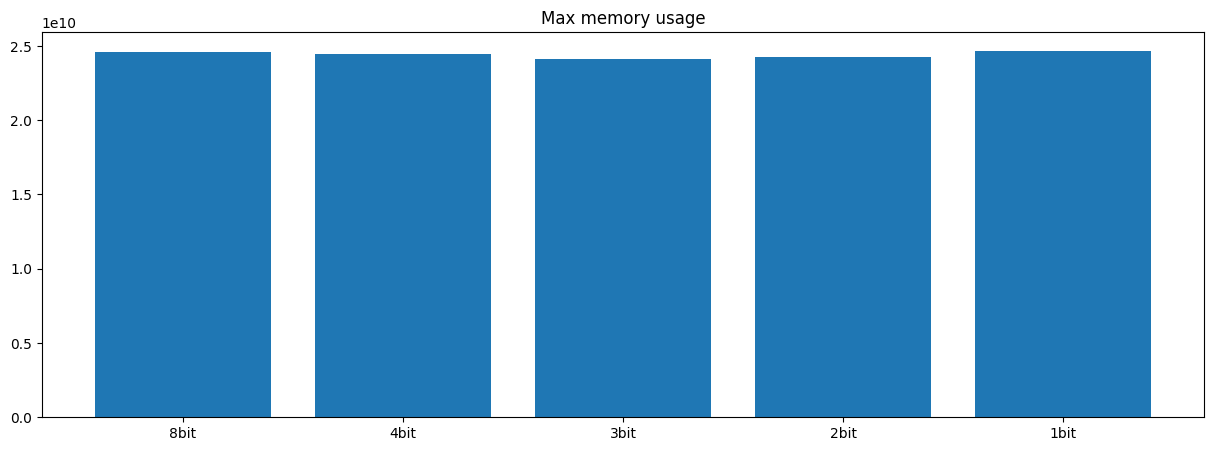

In [35]:
plt.figure(figsize=(15, 5))
plt.bar(mems['llama3'].keys(), mems['llama2'].values())
plt.title('Max memory usage')
plt.show()

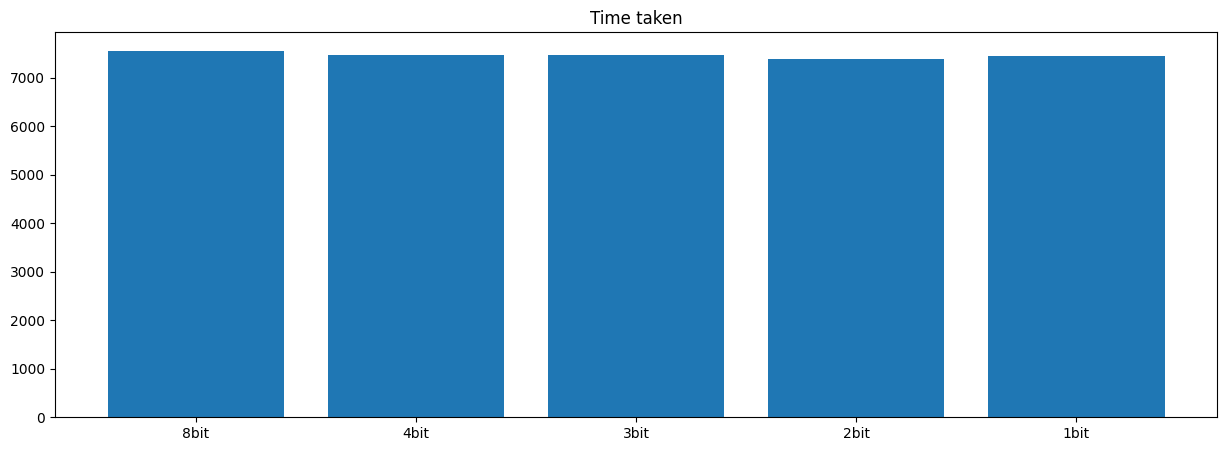

In [36]:
plt.figure(figsize=(15, 5))
plt.bar(times['llama3'].keys(), times['llama2'].values())
plt.title('Time taken')
plt.show()

**Conclusion for Llama3:** The observations carry over from llama2 to llama3. The only difference is the decrease in quality going from 3b to 2b is steeper (~52% for llama3 compared to ~30% for llama2)